In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Subset,DataLoader
import torch.optim as optim
import torchvision.datasets as datasets

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ,transforms.Resize((128, 128))
])

In [3]:

train_dataset=datasets.CelebA(
    root="C:/Users/maddo/Downloads/COdes from Work/Working on now",split='train',target_type='attr',transform=transform,download=True)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99058187..1.0].


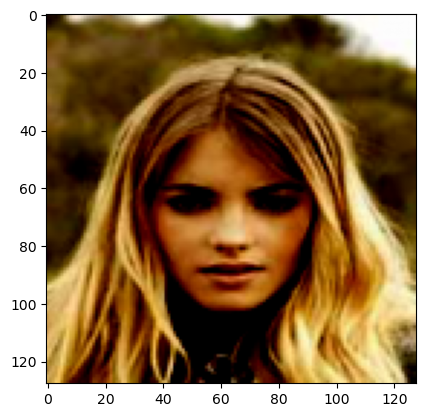

In [4]:
plt.imshow(train_dataset[18][0].permute(1, 2, 0))

In [5]:
x=torch.randn(1,10,20)

In [6]:
pa=nn.ConvTranspose2d(in_channels=1,out_channels=4,kernel_size=5,stride=4,padding=0)

In [7]:
ha=pa(x)

In [8]:
ha.shape

torch.Size([4, 41, 81])

In [9]:
xa=torch.randn(10,10,10)

In [10]:
train_loader = DataLoader(Subset(train_dataset, range(20000)), batch_size=100,shuffle=True )

In [11]:
class generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.cv1=nn.ConvTranspose2d(in_channels=1,out_channels=10,kernel_size=5,stride=4,padding=0)
        self.bn11=nn.BatchNorm2d(10)
        self.cv2=nn.ConvTranspose2d(in_channels=10,out_channels=5,kernel_size=5,stride=2,padding=0)
        self.bn12=nn.BatchNorm2d(5)
        self.fc1=nn.Linear(36125,500)
        self.bn1=nn.BatchNorm1d(500)
        self.fc2=nn.Linear(500,1000)
        self.bn2=nn.BatchNorm1d(1000)
        self.fc3=nn.Linear(1000,128*128*3)
        self.rel=nn.LeakyReLU(0.1)
        self.tanh=nn.Tanh()
        self.drp=nn.Dropout(0)
    def forward(self,x):
        x=self.cv1(x)
        x=self.bn11(x)
        x=self.cv2(x)
        x=self.bn12(x)
        batch_size=len(x)
        x=x.view(batch_size,-1)
        x=self.drp(self.rel(self.bn1(self.fc1(x))))
        x=self.rel(self.bn2(self.fc2(x)))
        return self.tanh(self.fc3(x))
        

In [12]:
class disc(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(128*128*3,30)
        self.fc2=nn.Linear(30,2000)
        self.fc3=nn.Linear(2000,1)
        self.rel=nn.LeakyReLU(0.1)
        self.sigm=nn.Sigmoid()
        self.drop=nn.Dropout(0)
    def forward(self,x):
        x=self.drop(self.rel(self.fc1(x)))
        x=self.drop(self.rel(self.fc2(x)))
        return self.sigm(self.fc3(x))

In [13]:
latentdim=(10,10)

In [14]:
gen=generator()
dis=disc()

In [15]:
criterion=nn.BCELoss()

In [16]:
gen1=gen.to('cuda')
dis1=dis.to('cuda')

In [17]:
discoptim=optim.Adam(dis1.parameters(),lr=0.0001,betas=(0.6, 0.9))

In [18]:
genoptim=optim.Adam(gen1.parameters(),lr=0.0002)

In [19]:
epoch=40

In [20]:
for i in range(epoch):
    id=0
    for x,y in train_loader:
        batch_size=len(x)
        x=x.view(batch_size,-1)
        fakelat=torch.randn(batch_size,latentdim[0],latentdim[1])
        fakelat=fakelat.unsqueeze(1)
        x=x.to('cuda')
        fakelat=fakelat.to('cuda')
        x = x * 2.0 - 1.0
        
        
        fakeimg=gen1(fakelat)
        fakeres=dis1(fakeimg.detach())
        realres=dis1(x)

        ones = torch.full((batch_size, 1), 0.9)  
        zero = torch.full((batch_size, 1), 0.1)
        ones=ones.to('cuda')
        zero=zero.to('cuda')
        loss_dis1=criterion(fakeres,zero)
        loss_dis2=criterion(realres,ones)
        loss=(loss_dis1+loss_dis2)/2

        discoptim.zero_grad()
        loss.backward()
        discoptim.step()

        for _ in range(2):
            fakelat=torch.randn(batch_size,latentdim[0],latentdim[1])
            fakelat=fakelat.unsqueeze(1)
            fakelat=fakelat.to('cuda')
            newfakes=dis1(fakeimg.detach())
            loss_gen=criterion(newfakes,ones)
            genoptim.zero_grad()
            loss_gen.backward()
            genoptim.step()
        id+=1
        print(f"Epoch number {i} index is {id} Disc loss is {loss} and gen loss is {loss_gen}")
        
        
        
        

Epoch number 0 index is 1 Disc loss is 0.7017930746078491 and gen loss is 0.7424919009208679
Epoch number 0 index is 2 Disc loss is 0.5301283597946167 and gen loss is 0.8240838646888733
Epoch number 0 index is 3 Disc loss is 0.5013294219970703 and gen loss is 0.9461086988449097
Epoch number 0 index is 4 Disc loss is 0.45117080211639404 and gen loss is 1.1090152263641357
Epoch number 0 index is 5 Disc loss is 0.3973272144794464 and gen loss is 1.3181337118148804
Epoch number 0 index is 6 Disc loss is 0.39363643527030945 and gen loss is 1.541684865951538
Epoch number 0 index is 7 Disc loss is 0.3557397127151489 and gen loss is 1.777230143547058
Epoch number 0 index is 8 Disc loss is 0.3505745828151703 and gen loss is 1.9962183237075806
Epoch number 0 index is 9 Disc loss is 0.3376964330673218 and gen loss is 2.1688461303710938
Epoch number 0 index is 10 Disc loss is 0.339619517326355 and gen loss is 2.2575879096984863
Epoch number 0 index is 11 Disc loss is 0.3343684673309326 and gen los

In [28]:
genz1=torch.randn(20,latentdim[0],latentdim[1])

In [29]:
genz1.shape

torch.Size([20, 10, 10])

In [30]:
genz1=genz1.unsqueeze(1)
genz1=genz1.to('cuda')
print(genz1.shape)
outs=gen1(genz1)

torch.Size([20, 1, 10, 10])


In [31]:
outs.shape

torch.Size([20, 49152])

In [35]:
n1=outs[1]

In [36]:
n1.shape

torch.Size([49152])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8942883..0.91566056].


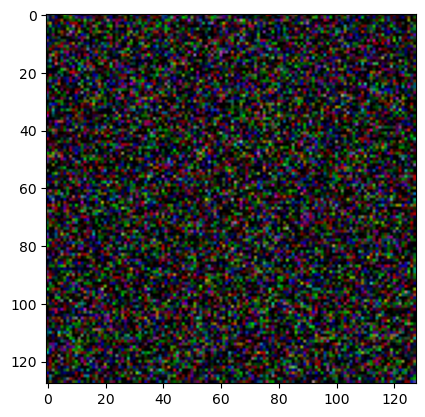

In [41]:
n1=outs[5]
rep=n1.detach().to('cpu')
rep = rep.view(3, 128, 128)
rep = rep.permute(1, 2, 0) 
plt.imshow(rep)